In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd

import re

## Features 

In [2]:
import re

indexes = []
features = []
with open('../homework2_exercise2/data/features', 'r') as f:
    for line in f.readlines():
        index, *feat = line.split(':')
        feat = ''.join(feat)
        feat = re.findall('"([^\"]*)"', feat)
        indexes.append(index)
    
        
        feat += [f.split('_')[0] for f in feat]
        feat = list(set(feat))
        
        features.append(feat)

In [3]:
one_hot = MultiLabelBinarizer()
mhe = one_hot.fit_transform(features)
df = pd.DataFrame(mhe)

In [4]:
df.rename(columns=lambda x: f'feat_{x}', inplace=True)
df = df.T.drop_duplicates().T
df = df.astype(bool)
df['theorem'] = indexes

In [5]:
del mhe
del features
del indexes

# Dataset

## Ones

In [6]:
indexes_train = []
premises = []

ones = []

with open('../homework2_exercise2/data/dependencies_train', 'r') as f:
    for line in f.readlines():
        index, *prem = line.split(':')
        prem = ''.join(prem).split()
        
        indexes_train.append(index)
        premises.append(prem)
        
        for p in prem:
            ones.append((index, p))

In [7]:
ones_df = pd.DataFrame(ones, columns=['theorem', 'premise']).drop_duplicates()

In [8]:
del ones
del premises
del indexes_train

## Zeros

In [9]:
chronology = pd.read_csv('../homework2_exercise2/data/chronology_backup', squeeze=True, names=['chronology'])
def get_available_theorems(name):
    return chronology.loc[:(chronology == name).argmax()-1]

In [10]:
used_premises = ones_df.groupby('theorem')['premise'].unique()

In [11]:
FALSE_EXAMPLES_RATIO = 3

dataset_zeros = []
for theorem, theorem_premises in ones_df.groupby('theorem')['premise']:
    available_theorems = get_available_theorems(theorem)
    zero_premises = np.setdiff1d(available_theorems, theorem_premises)
    
    zeros_chosen = zero_premises[np.random.randint(0, len(zero_premises), FALSE_EXAMPLES_RATIO * theorem_premises.shape[0])]
    dataset_zeros += list(zip(
        [theorem] * len(zeros_chosen),
        zeros_chosen
    ))

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
zeros_df = pd.DataFrame(dataset_zeros, columns=['theorem', 'premise'])

In [13]:
del dataset_zeros
del used_premises

##  Merging

In [14]:
zeros_df['useful'] = 0
ones_df['useful'] = 1
df_train = pd.concat([zeros_df, ones_df])

In [15]:
del zeros_df
del ones_df

In [16]:
def map_features(thm_prem_pairs):
    df_values = pd.merge(
        thm_prem_pairs, df,
        left_on=['theorem'],
        right_on=['theorem']
    )
    df_values = pd.merge(
        df_values, df,
        left_on=['premise'],
        right_on=['theorem'],
        suffixes=('_prem', '_thm')
    ).drop(['theorem_thm'], axis=1).rename(columns={'theorem_prem': 'theorem'})
    return df_values

In [17]:
df_train = map_features(df_train)
df_train.head()

,theorem,premise,useful,feat_0_prem,feat_1_prem,feat_2_prem,feat_3_prem,feat_4_prem,feat_6_prem,feat_7_prem,...,feat_10348_thm,feat_10353_thm,feat_10355_thm,feat_10358_thm,feat_10361_thm,feat_10362_thm,feat_10365_thm,feat_10368_thm,feat_10373_thm,feat_10376_thm
0,t100_tmap_1,fc3_partfun1,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,t24_tops_2,fc3_partfun1,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,t26_yellow_6,fc3_partfun1,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,t3_connsp_2,fc3_partfun1,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,t52_tops_2,fc3_partfun1,0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


# Training 

In [18]:
import lightgbm as lgb

In [19]:
# train test split
from sklearn.model_selection import train_test_split
train_theorems, test_theorems = train_test_split(df_train['theorem'].unique(), shuffle=True, train_size=0.8)

train = df_train['theorem'].isin(train_theorems)
test = df_train['theorem'].isin(test_theorems)

features = list(df_train.columns.drop(['theorem', 'premise', 'useful']))
y_name = 'useful'

/home/piotrek/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [22]:
train_data = lgb.Dataset(df_train[train][features], df_train[train][y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )
test_data = lgb.Dataset(df_train[test][features], df_train[test][y_name],
                        #categorical_feature=features,
                        free_raw_data=False
                        )

In [23]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'lambda_l2': 0.06,
    'verbose': 1,
    'threads': 6,
    'num_boost_round': 4000,
    'early_stopping_rounds': 200
}
model = lgb.train(
    parameters,
    train_data,
    valid_sets=test_data
)

MemoryError: 

# Suggested premises for new conjectures

In [22]:
conjs = pd.read_csv('../homework2_exercise2/data/conjectures_test', squeeze=True, names=['conjecture'])

In [23]:
usefulness_threshold = 0.8
def get_premises(conj):
    premises = get_available_theorems(conj)
    premises.name = 'premise'
    premises = premises.to_frame()
    premises['theorem'] = conj
    df_values = map_features(premises)
    premises['useful'] = model.predict(df_values.drop(['theorem', 'premise'], axis=1))
    premises = premises.sort_values(by='useful', ascending=False)
    #return premises['premise'].head(5)
    return premises[premises['useful'] > usefulness_threshold]['premise']

In [24]:
import sys
sys.path.append('..')
from homework2_exercise2.run_E_prover import find_proof

In [25]:
statements_path = '../homework2_exercise2/data/statements'
dirpath = '../homework2_exercise2/new_conjectures/'
with open(statements_path, 'r') as f:
    statements_lines = f.read().splitlines()
statements = {}
for l in statements_lines:
    statements[l.split(',')[0].replace('fof(', '')] = l


In [27]:
conj_results = []
for conj_name in conjs:
    premises_for_conj = get_premises(conj_name)
    proved = find_proof(conj_name, premises_for_conj, statements, dirpath)
    conj_results.append((conj_name, proved))

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t34_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t34_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t5_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t5_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t57_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t57_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t52_pre_topc NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t52_pre_topc.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t72_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t72_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t84_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t84_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t172_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t172_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t12_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t12_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t22_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t22_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t15_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t15_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t44_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t44_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t96_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t96_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t66_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t66_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t4_yellow_0 FOUND. Output in file ../homework2_exercise2/new_conjectures/t4_yellow_0.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t100_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t100_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t38_relset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t38_relset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t149_tmap_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t149_tmap_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t67_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t67_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t79_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t79_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t161_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t161_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t165_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t165_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t59_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t59_setfam_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t8_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t8_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t21_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t21_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t10_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t10_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t66_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t66_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t121_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t121_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t119_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t119_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t52_subset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t52_subset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t54_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t54_enumset1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t124_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t124_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t65_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t65_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t36_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t36_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t29_pre_topc NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t29_pre_topc.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t209_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t209_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t71_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t71_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t68_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t68_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t100_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t100_enumset1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t52_lattices NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t52_lattices.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t135_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t135_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t37_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t193_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t193_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t37_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t22_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t22_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t51_tex_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t51_tex_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t1_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t1_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t188_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t188_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t58_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t58_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t22_relset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t22_relset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t137_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t137_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t152_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t152_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t20_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t20_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t9_waybel_7 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t9_waybel_7.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t73_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t73_enumset1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t172_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t172_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t64_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t64_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_yellow19 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t23_yellow19.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t195_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t195_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t96_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t96_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t24_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t24_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t94_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t94_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t88_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t88_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t2_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t2_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t25_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t25_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t73_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t73_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t25_relset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t25_relset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t75_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t75_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t137_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t137_enumset1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t90_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t90_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t140_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t140_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t54_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t54_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_lattices FOUND. Output in file ../homework2_exercise2/new_conjectures/t18_lattices.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t17_waybel_7 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_waybel_7.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t33_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t33_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t121_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t121_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t9_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t9_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t62_pre_topc NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t62_pre_topc.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t22_tmap_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t22_tmap_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t27_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t27_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t39_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t39_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t86_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t86_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t41_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t41_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t170_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t170_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t47_relset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t47_relset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t75_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t75_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t60_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t60_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t131_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t131_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t205_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t205_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t48_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t48_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t17_compts_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_compts_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t62_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t62_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t35_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t35_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t93_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t93_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t65_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t65_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t23_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t6_yellow_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t6_yellow_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t68_tops_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t68_tops_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t41_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t41_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t70_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t70_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t37_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t61_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t61_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t34_filter_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t34_filter_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t28_subset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t28_subset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t128_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t128_enumset1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t87_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t87_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t14_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t14_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t104_tops_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t104_tops_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t14_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t14_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t47_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t47_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t46_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t46_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t41_lattice3 FOUND. Output in file ../homework2_exercise2/new_conjectures/t41_lattice3.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t81_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t81_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t58_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t58_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t65_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t65_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t18_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t31_yellow_0 FOUND. Output in file ../homework2_exercise2/new_conjectures/t31_yellow_0.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t117_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t117_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t101_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t101_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t79_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t79_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t11_waybel_9 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t11_waybel_9.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t17_finset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t17_finset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t17_tex_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t17_tex_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t110_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t110_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t86_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t86_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t54_relset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t54_relset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t37_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t213_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t213_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t56_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t56_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t49_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t49_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t29_yellow_6 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t29_yellow_6.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t12_wellord2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t12_wellord2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t108_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t108_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t38_tops_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t38_tops_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t50_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t50_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t63_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t63_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t8_lattice3 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t8_lattice3.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t40_tmap_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t40_tmap_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t38_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t38_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t17_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_setfam_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t50_subset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t50_subset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t63_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t63_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t154_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t154_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t60_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t60_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t93_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t93_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t43_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t43_enumset1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t88_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t88_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t30_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t30_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t16_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t16_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t44_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t44_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t8_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t8_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t141_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t141_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t22_waybel_9 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t22_waybel_9.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t45_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t45_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t56_filter_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t56_filter_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t47_subset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t47_subset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t167_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t167_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t18_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t67_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t67_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t42_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t42_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t26_compts_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t26_compts_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t56_setfam_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t56_setfam_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t32_wellord1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t32_wellord1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t62_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t62_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_yellow19 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t18_yellow19.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t16_subset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t16_subset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t59_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t59_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t26_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t26_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t47_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t47_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t50_orders_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t50_orders_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t10_waybel_9 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t10_waybel_9.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t56_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t56_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t13_lattice3 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t13_lattice3.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t52_relset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t52_relset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t23_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t1_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t1_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t69_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t69_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t29_wellord2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t29_wellord2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t81_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t81_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t41_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t41_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t125_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t125_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t91_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t91_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t125_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t125_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_ordinal1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t37_ordinal1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t37_setfam_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t38_waybel_7 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t38_waybel_7.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t16_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t16_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t104_xboole_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t104_xboole_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t53_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t53_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t22_lattices FOUND. Output in file ../homework2_exercise2/new_conjectures/t22_lattices.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t61_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t61_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t35_tops_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t35_tops_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t144_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t144_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t109_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t109_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t49_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t49_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t12_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t12_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t21_wellord1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t21_wellord1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t111_xboole_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t111_xboole_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t63_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t63_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t61_tex_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t61_tex_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_wellord1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t18_wellord1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t95_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t95_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t17_yellow_6 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_yellow_6.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t45_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t45_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t26_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t26_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t20_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t20_setfam_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t55_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t55_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t21_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t21_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t162_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t162_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t14_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t14_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t64_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t64_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t43_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t43_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t53_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t53_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t138_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t138_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t41_filter_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t41_filter_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t76_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t76_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t28_pre_topc NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t28_pre_topc.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t50_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t50_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t54_filter_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t54_filter_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t47_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t47_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t119_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t119_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t21_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t21_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t175_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t175_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t217_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t217_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t22_connsp_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t22_connsp_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t6_yellow_0 FOUND. Output in file ../homework2_exercise2/new_conjectures/t6_yellow_0.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t29_orders_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t29_orders_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t97_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t97_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t5_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t5_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t77_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t77_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t23_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t160_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t160_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t73_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t73_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_waybel_7 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t37_waybel_7.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t55_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t55_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t66_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t66_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t32_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t32_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t115_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t115_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t42_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t42_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t96_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t96_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t183_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t183_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t61_pre_topc NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t61_pre_topc.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t40_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t40_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t44_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t44_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t91_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t91_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t36_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t36_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t16_finset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t16_finset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t176_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t176_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_connsp_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t23_connsp_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t111_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t111_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t187_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t187_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t139_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t139_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t68_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t68_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t10_wellord1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t10_wellord1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t159_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t159_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t12_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t12_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t21_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t21_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t54_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t54_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t84_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t84_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t65_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t65_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t40_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t40_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t138_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t138_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t8_waybel_9 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t8_waybel_9.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t94_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t94_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_relset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t23_relset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t7_yellow19 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t7_yellow19.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t141_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t141_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t53_setfam_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t53_setfam_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t193_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t193_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t29_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t29_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t67_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t67_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t28_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t28_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t92_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t92_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t50_wellord1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t50_wellord1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t103_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t103_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t43_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t43_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t123_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t123_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t74_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t74_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t196_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t196_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t200_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t200_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t182_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t182_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t17_relset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t17_relset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t109_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t109_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t103_tops_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t103_tops_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t84_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t84_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t8_filter_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t8_filter_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t133_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t133_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t100_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t100_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t20_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t20_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t79_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t79_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t53_relset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t53_relset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t102_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t102_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t15_yellow19 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t15_yellow19.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t89_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t89_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t143_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t143_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t171_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t171_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t29_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t29_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_lattice3 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t37_lattice3.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t49_subset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t49_subset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t16_waybel_9 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t16_waybel_9.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t47_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t47_enumset1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t18_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t95_mcart_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t95_mcart_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t69_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t69_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t48_wellord1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t48_wellord1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t13_yellow_0 FOUND. Output in file ../homework2_exercise2/new_conjectures/t13_yellow_0.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t25_yellow_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t25_yellow_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t31_relset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t31_relset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t88_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t88_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t102_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t102_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t110_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t110_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t27_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t27_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t42_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t42_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t41_yellow_6 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t41_yellow_6.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t77_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t77_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t75_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t75_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t1_waybel_9 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t1_waybel_9.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t23_setfam_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t125_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t125_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t34_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t34_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_lattices FOUND. Output in file ../homework2_exercise2/new_conjectures/t23_lattices.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t92_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t92_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t46_lattice3 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t46_lattice3.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t71_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t71_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t32_orders_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t32_orders_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t150_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t150_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t103_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t103_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t135_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t135_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t27_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t27_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t49_waybel_7 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t49_waybel_7.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t144_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t144_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t14_yellow_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t14_yellow_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t19_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t19_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t128_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t128_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t22_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t22_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t41_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t41_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t30_tops_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t30_tops_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t51_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t51_setfam_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t106_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t106_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t13_waybel_9 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t13_waybel_9.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t40_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t40_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t122_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t122_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t201_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t201_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t46_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t46_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t46_filter_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t46_filter_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t22_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t22_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t16_yellow_6 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t16_yellow_6.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t39_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t39_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t176_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t176_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t55_tmap_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t55_tmap_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_wellord1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t23_wellord1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t46_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t46_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t18_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t121_tmap_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t121_tmap_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t17_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t17_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t25_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t25_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t39_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t39_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t60_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t60_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t51_lattice3 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t51_lattice3.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t32_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t32_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t33_waybel_9 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t33_waybel_9.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t45_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t45_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t33_yellow_0 FOUND. Output in file ../homework2_exercise2/new_conjectures/t33_yellow_0.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t104_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t104_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t48_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t48_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t92_tops_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t92_tops_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t116_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t116_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t2_lattice3 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t2_lattice3.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t18_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t28_yellow19 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t28_yellow19.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t16_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t16_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t69_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t69_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_compts_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t18_compts_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t8_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t8_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t92_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t92_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t75_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t75_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t104_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t104_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t24_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t24_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t107_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t107_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t6_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t6_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t85_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t85_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t108_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t108_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t4_setfam_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t4_setfam_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t81_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t81_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t57_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t57_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t6_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t6_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t85_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t85_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t63_subset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t63_subset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t97_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t97_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t64_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t64_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t18_setfam_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t19_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t19_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t107_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t107_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t105_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t105_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t84_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t84_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t77_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t77_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t39_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t39_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t92_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t92_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t23_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t23_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t173_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t173_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t147_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t147_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t142_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t142_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_yellow_6 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t37_yellow_6.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t95_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t95_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t137_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t137_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t48_filter_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t48_filter_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t35_yellow_0 FOUND. Output in file ../homework2_exercise2/new_conjectures/t35_yellow_0.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t7_wellord2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t7_wellord2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t55_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t55_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t153_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t153_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t136_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t136_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t136_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t136_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t47_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t47_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t15_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t15_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t14_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t14_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t198_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t198_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t24_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t24_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t50_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t50_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t70_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t70_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t78_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t78_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t18_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t20_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t20_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t24_yellow19 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t24_yellow19.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t71_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t71_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t68_tops_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t68_tops_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t152_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t152_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t112_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t112_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t74_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t74_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t192_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t192_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t40_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t40_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t86_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t86_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t152_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t152_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t57_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t57_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t36_yellow19 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t36_yellow19.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t9_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t9_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t141_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t141_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t11_wellord2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t11_wellord2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t10_setfam_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t10_setfam_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t44_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t44_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t88_funct_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t88_funct_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t62_orders_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t62_orders_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t61_enumset1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t61_enumset1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t2_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t2_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t19_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t19_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_subset_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t18_subset_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t15_finset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t15_finset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t27_relat_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t27_relat_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t83_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t83_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t7_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t7_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t31_lattices NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t31_lattices.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t46_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t46_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t93_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t93_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t54_tops_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t54_tops_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t114_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t114_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t26_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t26_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t54_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t54_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t8_connsp_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t8_connsp_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t3_yellow_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t3_yellow_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t76_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t76_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t116_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t116_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t20_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t20_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t65_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t65_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t67_orders_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t67_orders_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t33_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t33_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t51_funct_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t51_funct_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t63_tops_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t63_tops_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t30_orders_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t30_orders_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t129_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t129_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t48_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t48_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t85_funct_2 FOUND. Output in file ../homework2_exercise2/new_conjectures/t85_funct_2.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t156_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t156_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t58_waybel_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t58_waybel_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t25_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t25_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t123_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t123_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t68_tex_2 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t68_tex_2.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t3_yellow_0 FOUND. Output in file ../homework2_exercise2/new_conjectures/t3_yellow_0.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_yellow19 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t37_yellow19.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t52_ordinal1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t52_ordinal1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t149_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t149_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t38_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t38_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t33_yellow_6 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t33_yellow_6.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t18_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t18_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t58_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t58_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t96_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t96_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t101_xboole_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t101_xboole_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t41_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t41_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t86_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t86_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t87_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t87_enumset1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t91_mcart_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t91_mcart_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t99_zfmisc_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t99_zfmisc_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t6_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t6_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t10_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t10_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t139_tmap_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t139_tmap_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t161_funct_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t161_funct_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t37_yellow_0 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t37_yellow_0.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t43_zfmisc_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t43_zfmisc_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t30_wellord1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t30_wellord1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t46_subset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t46_subset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t29_relset_1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t29_relset_1.E_output


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t74_relat_1 NOT found. Output saved in file ../homework2_exercise2/new_conjectures/t74_relat_1.E_output 


/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


Proof of conjecture t77_enumset1 FOUND. Output in file ../homework2_exercise2/new_conjectures/t77_enumset1.E_output


In [30]:
pd.DataFrame(conj_results).to_csv('results.csv')

In [22]:
conj_name

NameError: name 'conj_name' is not defined

In [78]:
premises_for_conj.shape

(4,)

In [55]:
conj_name in premises_for_conj

False

In [59]:
chronology[(chronology == 't5_funct_2')]

1478    t5_funct_2
Name: chronology, dtype: object

In [57]:
(premises_for_conj == 't5_funct_2').sum()

1

In [53]:
conj_name

't5_funct_2'

In [48]:
a.shape

(195, 3)

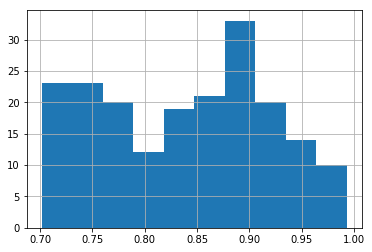

In [49]:
a['useful'].hist()

In [45]:
a['useful'].quantile(0.95)


0.6479658909399986

In [32]:
available_premises_for_conj(conjs[0]).to_frame()

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


,premises
0,dt_k5_xboole_0
1,dt_k4_xboole_0
2,idempotence_k2_xboole_0
3,d3_xboole_0
4,commutativity_k5_xboole_0
5,d5_xboole_0
6,d6_xboole_0
7,antisymmetry_r2_hidden
8,commutativity_k2_xboole_0
9,dt_k2_xboole_0


In [57]:
available_premises_for_conj('t57_tmap_1').tail()

/home/piotrek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


4561          fc6_yellow19
4562    dt_o_2_13_yellow19
4563          t38_yellow19
4564          t34_waybel_0
4565            t5_funct_2
dtype: object

In [2]:
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd

In [11]:
df = pd.DataFrame([[1,2], [1,3],[3,5], [2,4]])
df.head()

,0,1
0,1,2
1,1,3
2,3,5
3,2,4


In [26]:
split = train_test_split(df[0].unique(), shuffle=True)

In [27]:
df[df[0].isin(split[0])]

,0,1
2,3,5
3,2,4


In [28]:
df

,0,1
0,1,2
1,1,3
2,3,5
3,2,4
